In [1]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import glob
import os
import seaborn as sns

In [2]:
files = glob.glob(os.path.join('QATAR/PKL', "*.pkl.gz"))
files_done = []
for file in files:
        df = pd.read_pickle(file)
        comments_df_initial = df[df['in_reply_to_user_id_str'].notnull()].copy()
        del df
        temp_comments_df = pd.DataFrame({
            'user_id': comments_df_initial['user.id_str'].apply(int),
            'user_name': comments_df_initial['user.screen_name'],
            'commented_user_id': comments_df_initial['in_reply_to_user_id_str'].apply(int),
            'commented_user_name': comments_df_initial['in_reply_to_screen_name']
        })
        temp_comments_df = temp_comments_df[temp_comments_df['user_id'] != temp_comments_df['commented_user_id']]
        files_done.append(temp_comments_df)
comments_df = pd.concat(files_done, ignore_index=True)


In [3]:

df_users = comments_df[['user_id', 'user_name']].rename(columns={'user_id': 'user_id', 'user_name': 'name'})

df_commented = comments_df[['commented_user_id', 'commented_user_name']].rename(
    columns={'commented_user_id': 'user_id', 'commented_user_name': 'name'}
)
index_df = pd.concat([df_users, df_commented]).drop_duplicates().reset_index(drop=True)


In [4]:

grouped_comments = comments_df.groupby(['user_id', 'commented_user_id']).size().reset_index(name='count')
grouped_comments = grouped_comments.sort_values(by='count', ascending=False)

In [ ]:

G = nx.DiGraph()

for _, row in grouped_comments.iterrows():
    G.add_edge(row['user_id'], row['commented_user_id'], weight=row['count'])

nx.write_gexf(G, "network_comment_QAT.gexf")

GEPHI STUFF

In [5]:
communities = pd.read_csv('COMMENT_NETWORK_QAT/QATAR COMMUNITIES.csv').rename(
    columns={'Id': 'user_id', 'modularity_class': 'community'}
)

grouped_comments['user_id'] = grouped_comments['user_id'].astype(int)

df_merged = pd.merge(grouped_comments, communities, on='user_id', how='inner').rename(columns={'community': 'community_user'})

df_merged = pd.merge(df_merged, communities, left_on='commented_user_id', right_on='user_id', how='inner').rename(
    columns={'community': 'community_commented_user'}
)

df_communities = df_merged.copy().rename(columns={'user_id_x': 'user_id'})
df_same_community = df_merged[df_merged['community_user'] == df_merged['community_commented_user']].copy().rename(
    columns={'user_id_x': 'user_id'}
)
df_same_community.drop(columns=['user_id_y'], inplace=True)

In [6]:
inbound = df_communities.groupby(["community_user", "community_commented_user"])["count"].sum().reset_index()

inbound_graph = inbound.rename(columns={
    "community_user": "initiating_community",
    "community_commented_user": "receiving_community",
    "count": "weight"
})

inbound_graph = inbound_graph[inbound_graph["initiating_community"] != inbound_graph["receiving_community"]]

G = nx.DiGraph()
for _, row in inbound_graph.iterrows():
    source = row["initiating_community"]
    target = row["receiving_community"]
    weight = row["weight"]
    G.add_edge(source, target, weight=weight)

nx.write_gexf(G, "communities_comment_QAT.gexf")

inbound_pivot = inbound.pivot(index="community_user", columns="community_commented_user", values="count").fillna(0)
communities_list = sorted(set(inbound_pivot.index).union(inbound_pivot.columns))
inbound_pivot = inbound_pivot.reindex(index=communities_list, columns=communities_list, fill_value=0)

sym_df = pd.DataFrame(index=communities_list, columns=communities_list, data=0)
for i in communities_list:
    for j in communities_list:
        sym_df.loc[i, j] = inbound_pivot.loc[i, j] + inbound_pivot.loc[j, i]

sym_df["Percentage_Self"] = [
    (sym_df.loc[i, i] / sym_df.loc[i].sum() * 100) if sym_df.loc[i].sum() != 0 else 0
    for i in sym_df.index
]

In [7]:
pagerank_results = []

for community_user, group in df_same_community.groupby('community_user'):
    G = nx.DiGraph()
    for _, row in group.iterrows():
        G.add_edge(row['user_id'], row['commented_user_id'], weight=row['count'])
    pr = nx.pagerank(G, weight='weight')
    for user, score in pr.items():
        pagerank_results.append({'community': community_user, 'user_id': user, 'pagerank': score})

pagerank_df = pd.DataFrame(pagerank_results)
pagerank_df = pd.merge(pagerank_df, index_df, on='user_id', how='outer').fillna(0)
pagerank_df = pagerank_df.sort_values(['community', 'pagerank'], ascending=[True, False])

In [8]:
out_degree = df_same_community.groupby('user_id')['count'].sum().reset_index(name='out_degree')
in_degree = df_same_community.groupby('commented_user_id')['count'].sum().reset_index(name='in_degree')
in_degree.rename(columns={'commented_user_id': 'user_id'}, inplace=True)

degrees_community = pd.merge(out_degree, in_degree, on='user_id', how='outer').fillna(0)
user_stats_community = pd.merge(degrees_community, index_df, on='user_id', how='outer').fillna(0)
user_stats_community['total'] = user_stats_community['out_degree'] + user_stats_community['in_degree']

final_user_stats_community = pd.merge(user_stats_community, communities, on='user_id', how='inner')

In [9]:
for community in sorted(final_user_stats_community['community'].unique()):
    community_df = final_user_stats_community[final_user_stats_community['community'] == community]
    pagerank_top = pagerank_df[pagerank_df['community'] == community].sort_values(by='pagerank', ascending=False).head(10)

    top_in_degree = community_df.sort_values(by='in_degree', ascending=False).head(10)
    top_total = community_df.sort_values(by='total', ascending=False).head(5)
    top_out_degree = community_df.sort_values(by='out_degree', ascending=False).head(5)

    percentage_self = sym_df.loc[community, "Percentage_Self"] if "Percentage_Self" in sym_df.columns else 0.0
    row = sym_df.loc[community].drop(labels=["Percentage_Self"], errors="ignore")
    if community in row.index:
        row = row.drop(community)
    total_other = row.sum()
    top3 = row.nlargest(3) if total_other != 0 else pd.Series()

    print(f"\n===== Community {community} =====")
    print(f"Size: {len(community_df)} users")
    
    print("\nTop 10 users by PageRank:")
    print(pagerank_top[['name', 'pagerank']].reset_index(drop=True))

    print("\nTop 10 by In Degree:")
    print(top_in_degree[['name', 'in_degree']].reset_index(drop=True))

    print("\nTop 5 by Out Degree:")
    print(top_out_degree[['name', 'out_degree']].reset_index(drop=True))

    print("\nTop 5 by Total Degree:")
    print(top_total[['name', 'total']].reset_index(drop=True))

    print(f"\nPercentage of interactions within same community: {percentage_self:.2f}%")
    
    print("Most interacted with communities:")
    if top3.empty:
        print("None.")
    else:
        for comm, count in top3.items():
            pct = (count / total_other) * 100
            print(f"Community {comm}: {pct:.2f}%")


===== Community 0 =====
Size: 313 users

Top 10 users by PageRank:
              name  pagerank
0  fifaworldcup_pt  0.193111
1     futebol_info  0.044844
2           sportv  0.034144
3     Budweiser_Br  0.032516
4      TNTSportsBR  0.027646
5  DoentesPFutebol  0.020931
6      galvaobueno  0.019864
7      mundodabola  0.019131
8          choquei  0.015044
9  Snaihtniroccccc  0.014408

Top 10 by In Degree:
              name  in_degree
0  fifaworldcup_pt     3888.0
1     futebol_info      697.0
2      TNTSportsBR      480.0
3           sportv      230.0
4          choquei      208.0
5          geglobo      189.0
6      SofascoreBR      120.0
7      mundodabola      117.0
8     desimpedidos      102.0
9  DoentesPFutebol      102.0

Top 5 by Out Degree:
              name  out_degree
0   cartolaexpress       575.0
1   gabriel_amaiss       460.0
2           sportv       406.0
3  AustineStanley4       355.0
4       ZeDelivery       315.0

Top 5 by Total Degree:
              name   total
0 

C:\Users\Benji\AppData\Local\Temp\ipykernel_33004\3868277381.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='community', y='size', data=community_sizes, palette='viridis')


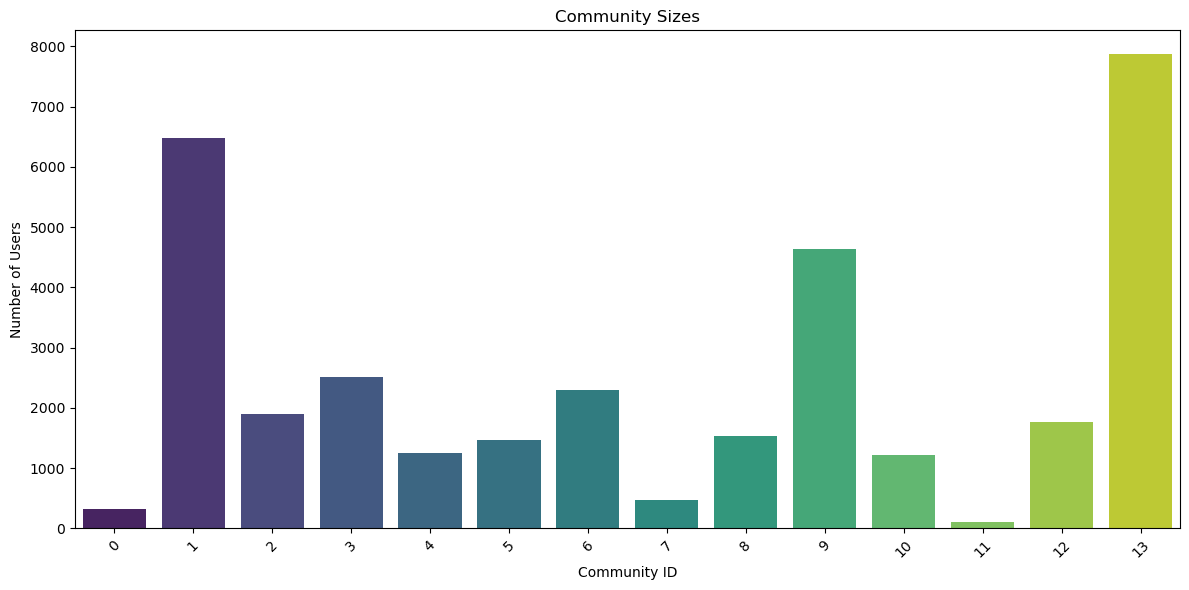

C:\Users\Benji\AppData\Local\Temp\ipykernel_33004\3868277381.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='community', y='Percentage_Self', data=percentage_self_df, palette='coolwarm')


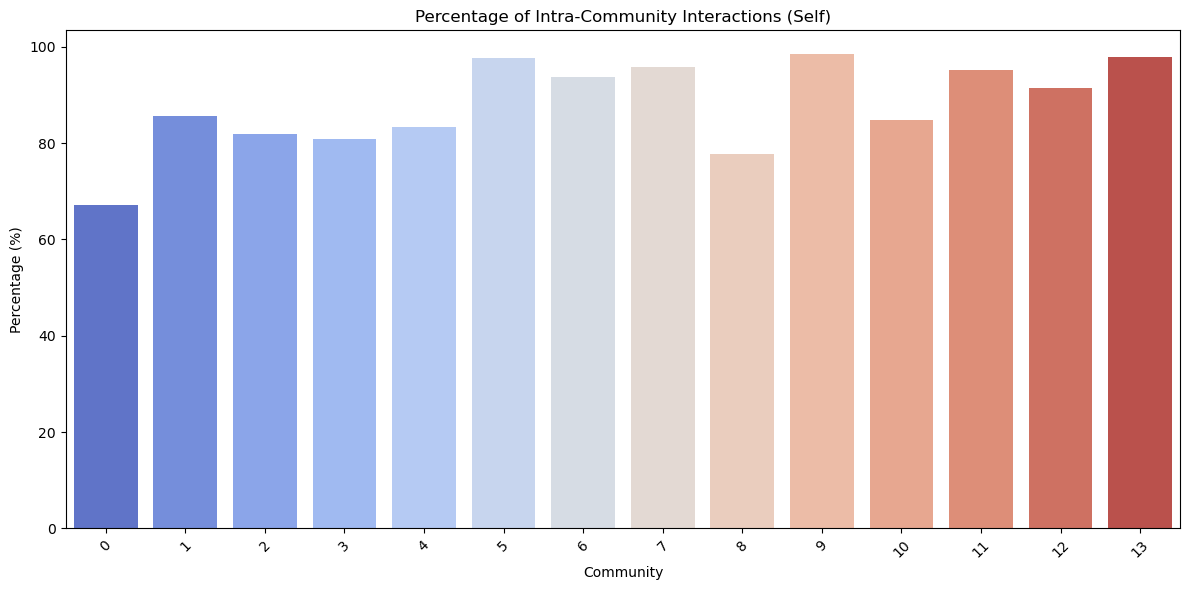

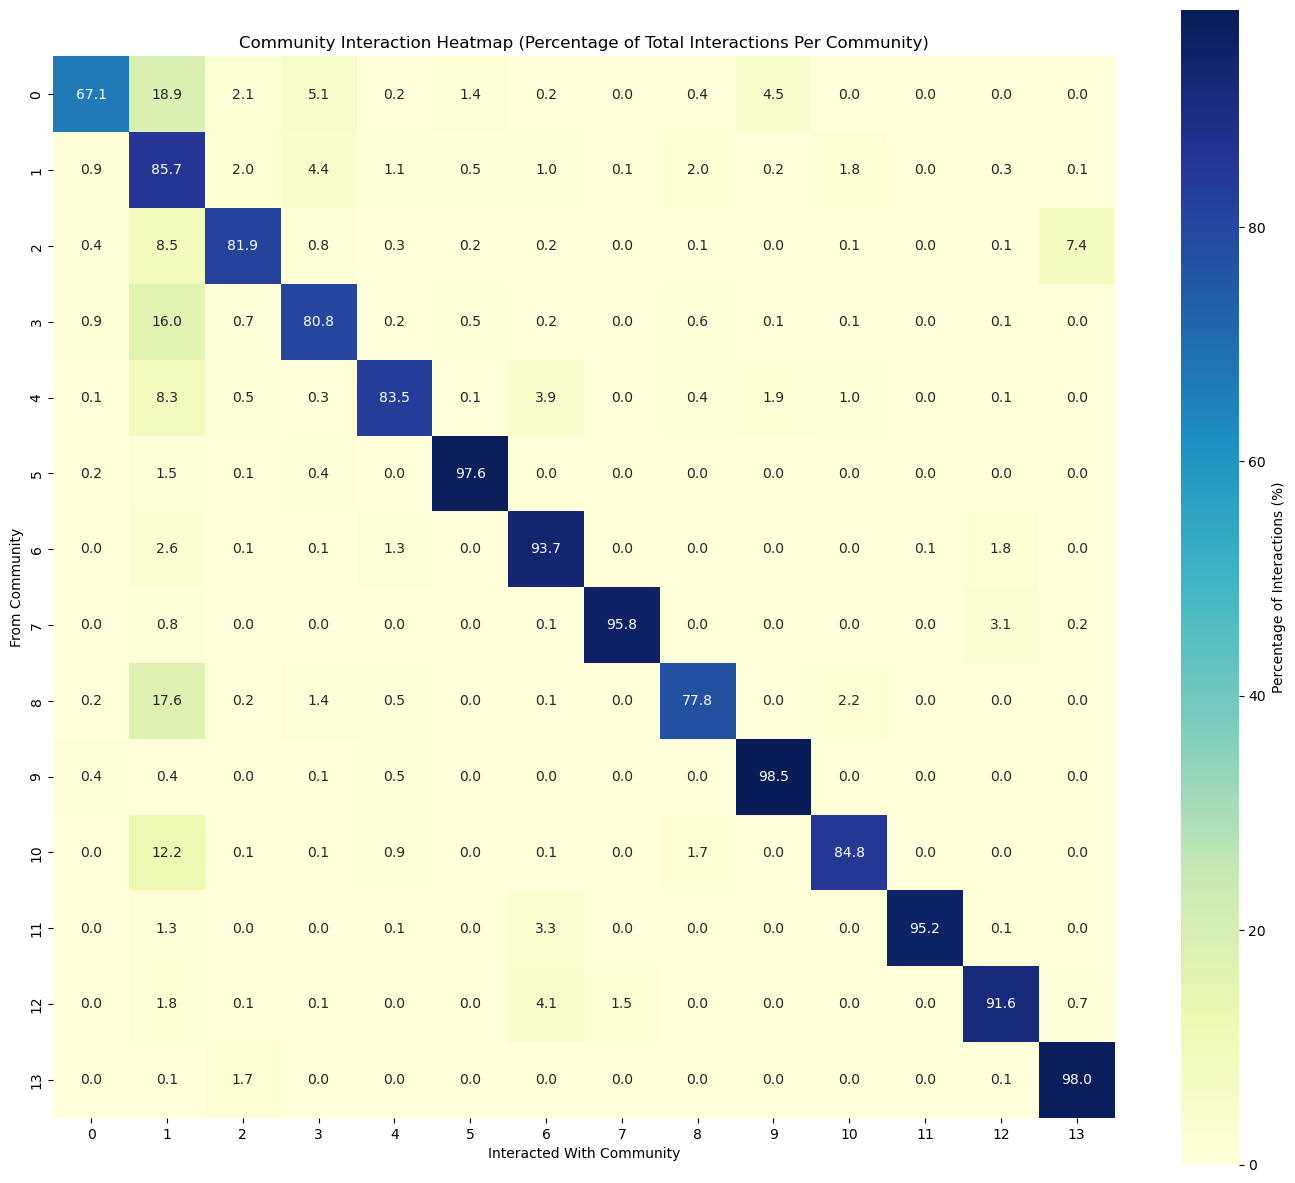

In [10]:
community_sizes = (
    final_user_stats_community.groupby('community')
    .size()
    .reset_index(name='size')
    .sort_values(by='size', ascending=False)
)

plt.figure(figsize=(12, 6))
sns.barplot(x='community', y='size', data=community_sizes, palette='viridis')
plt.title('Community Sizes')
plt.xlabel('Community ID')
plt.ylabel('Number of Users')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

percentage_self_df = sym_df[['Percentage_Self']].reset_index().rename(columns={'index': 'community'})
percentage_self_df['Percentage_Self'] = percentage_self_df['Percentage_Self'].astype(float)

plt.figure(figsize=(12, 6))
sns.barplot(x='community', y='Percentage_Self', data=percentage_self_df, palette='coolwarm')
plt.title('Percentage of Intra-Community Interactions (Self)')
plt.xlabel('Community')
plt.ylabel('Percentage (%)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

interaction_pct_df = sym_df.drop(columns='Percentage_Self').copy()

interaction_pct_normalized = interaction_pct_df.div(interaction_pct_df.sum(axis=1), axis=0) * 100

interaction_pct_normalized.fillna(0, inplace=True)

plt.figure(figsize=(14, 12))
sns.heatmap(
    interaction_pct_normalized,
    cmap='YlGnBu',
    square=True,
    annot=True,
    fmt=".1f",
    cbar_kws={'label': 'Percentage of Interactions (%)'}
)
plt.title('Community Interaction Heatmap (Percentage of Total Interactions Per Community)')
plt.xlabel('Interacted With Community')
plt.ylabel('From Community')
plt.tight_layout()
plt.show()